# Final Modeling Notebook Intro

Authors: Tim Gorman, Yu Cao, Ling Zhou

In this notebook we take the data output from data_prep2.0 ("./foursquare-location-matchin/cao_code/data_prep2.0.ipynb") </br>
This data has some important aspects: </br>
* Curated Ground Truth Data
    * This is the raw data from kaggle after removing nans, noise and reducing to only data with country_1 and country_2 both being 'US'.
    * Label:
        * match
            * Indicates whether two ids represent the same point of interest
    * Features:
        * id_1, id_2
        * Modeling Features: 
        * name_1, name_2 
        * latitude_1, latitude_2 
        * longitude_1, longitude_2 
        * address_1, address_2
        * city_1, city_2
        * state_1, state_2
        * country_1, country_2
        * url_1, url_2
        * phone_1, phone_2
        * categories_1, categories_2
* Differenced Data
    * Lat./Long. Differences
        * Simply Euclidean Differences (geo_diff)
        * Angular Difference (geo_theta_diff)
    * String differences
        * Three different ways to calucate differences
            * Sequence Matching (*_seq)
            * Levenshtein Distance (*_lev)
            * Cosine Similarity (*_csim)

We then take the different ways to difference data and run them through a Logistic regression model to see which differencing method performs best. Based on this, the best method will be sent through a random forest classification model. At the end of the notebook we'll compare all of the results against two naive models.
  

# Library Imports

In [1]:
#Library Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split, cross_validate,
                                    StratifiedKFold, GridSearchCV, RandomizedSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, roc_auc_score, f1_score,
                            accuracy_score, precision_score, recall_score,
                            precision_recall_curve, roc_curve)
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [2]:
# This data is the curated data that comes out of "data_prep2.0"
path = '../data_raw/pairs_us_diffs.csv'
# r"..\data_curated\pairs_us_diffs.csv"
data = pd.read_csv(path, low_memory = False)

In [3]:
# A dictionary that defines which features to use when modeling with different string metrics 
# (sequence matching, cosine similarity, levenshtein).
feature_dict = {'x_col_csim': ['geo_theta_diff', 'name_csim', 'address_csim',
       'city_csim', 'state_csim', 'zip_csim', 'url_csim', 'phone_csim',
       'categories_csim'], 
                'x_col_seq':['geo_theta_diff', 'name_diff_seq',
       'address_diff_seq', 'city_diff_seq','state_diff_seq', 'zip_diff_seq',
       'url_diff_seq', 'phone_diff_seq', 'categories_diff_seq'],
               'x_col_lev':['geo_theta_diff', 'name_diff_lev',
       'address_diff_lev', 'city_diff_lev','state_diff_lev', 'zip_diff_lev',
       'url_diff_lev', 'phone_diff_lev', 'categories_diff_lev'] }

# Function Definitions

In [39]:
# Defining Modeling Functions
def logistic_regression_pipe(features, labels):
    x_train, x_test, y_train, y_test = train_test_split(features, labels,
                                                    shuffle      = True,
                                                    random_state = 614,
                                                    test_size    = 0.2,
                                                    stratify     = labels)
    skf  = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 614)
    lreg = LogisticRegression()
    #HyperParameters
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [100, 50, 10, 5, 1.0, 0.5, 0.1, 0.05, 0.01]
    grid = dict(solver=solvers,penalty=penalty,C=c_values)
    grid_search = GridSearchCV(estimator=lreg, param_grid=grid, n_jobs=-1, cv=skf, scoring='accuracy',error_score=0)
    grid_result = grid_search.fit(x_train, y_train)
    # print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    print("Best mean test score {:5.5f} using {}".format(grid_result.best_score_, grid_result.best_params_))
    means  = grid_result.cv_results_['mean_test_score']
    stds   = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    print("mean     std             param")
    print("------------------------------"*2)
    for mean, stdev, param in zip(means, stds, params):
        # print("%f (%f) with: %r" % (mean, stdev, param))
        print("{:5.5f}  ({:5.5f}) with: {}".format(mean, stdev, param))
    return grid_result.best_params_

def random_forest_pipe(features, labels):
    x_train, x_test, y_train, y_test = train_test_split(features, labels,
                                                    shuffle      = True,
                                                    random_state = 614,
                                                    test_size    = 0.2,
                                                    stratify     = data['match'])
    #Defining Estimators
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1200, num = 6)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [2, 4, 10]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators'     : n_estimators,
                   'max_features'     : max_features,
                   'max_depth'        : max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf' : min_samples_leaf,
                   'bootstrap'        : bootstrap}
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, 
                                   param_distributions = random_grid, 
                                   n_iter = 10, cv = 3, verbose=2, 
                                   random_state=614, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(x_train, y_train)
    
    print(rf_random.best_params_)
    
    return rf_random.best_params_


# Logistic Regression With Hyperparameter tuning and K-fold Cross_validation

In [5]:
best_params_dict = {}
for features in feature_dict:
    print(40*'-.')
    print(features)
    best_params = logistic_regression_pipe(features = data[feature_dict[features]], labels = data['match'])
    best_params_dict[features] = best_params

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
x_col_csim
Best mean test score 0.73952 using {'C': 0.05, 'penalty': 'l2', 'solver': 'newton-cg'}
mean     std             param
------------------------------------------------------------
0.73923  (0.00253) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.73922  (0.00252) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.73924  (0.00251) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.73923  (0.00253) with: {'C': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
0.73922  (0.00252) with: {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
0.73924  (0.00251) with: {'C': 50, 'penalty': 'l2', 'solver': 'liblinear'}
0.73924  (0.00255) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.73922  (0.00253) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.73925  (0.00253) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.73923  (0.00254) with: {'C': 5, 'penalty': 'l2', 'solver': 'n

In [6]:
best_params_dict['x_col_lev']

{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

What I get from above is that the levenshtein distance works as the best metric. I ran this twice with "geo_diff" and "geo_theta_diff" (not shown with "geo_diff"). They give nearly identical results so I'll stick with "geo_theta_diff" because I believe it to be the most accurate metric. </br> </br>
Here's what I will use for the "best logistic regression" on the test set.
```
x_col_lev
Best: 0.760583 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
```

In [7]:
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 614)

In [8]:
lreg_best = LogisticRegression(penalty = best_params_dict['x_col_lev']['penalty'], 
                               solver  = best_params_dict['x_col_lev']['solver'], 
                               C       = best_params_dict['x_col_lev']['C'])

In [9]:
#Defining Test Set that will be used for next logistic regression
x_train, x_test, y_train, y_test = train_test_split(data[feature_dict['x_col_lev']], data['match'],
                                                    shuffle      = True,
                                                    random_state = 614,
                                                    test_size    = 0.2,
                                                    stratify     = data['match'])

In [10]:
scores = cross_validate(lreg_best, x_train, y_train, 
                        cv      = skf, 
                        scoring = ['accuracy', 'roc_auc', 'f1', 'average_precision', 'jaccard'], 
                        n_jobs  = -1)

Results

In [11]:
print('Mean Accuracy')
print(np.mean(scores['test_accuracy']))
print('Mean roc_auc')
print(np.mean(scores['test_roc_auc']))
print('Mean F1')
print(np.mean(scores['test_f1']))
print('Mean Average Precision')
print(np.mean(scores['test_average_precision']))
print('Mean Jaccard')
print(np.mean(scores['test_jaccard']))

Mean Accuracy
0.7605722218327654
Mean roc_auc
0.7403875779217521
Mean F1
0.8486132699349389
Mean Average Precision
0.8587660397355534
Mean Jaccard
0.7370392880547117


## Logistic Regression on Test Set

In [12]:
lreg_best.fit(x_train, y_train)
y_pred = lreg_best.predict(x_test)

In [13]:
confusion_matrix(y_test, y_pred)

array([[ 2075,  4544],
       [ 1141, 15781]])

In [14]:
roc_auc_score(y_test, y_pred)

0.623032222942199

In [15]:
f1_score(y_test, y_pred)

0.8473702580073563

In [16]:
accuracy_score(y_test, y_pred)

0.7585064355804766

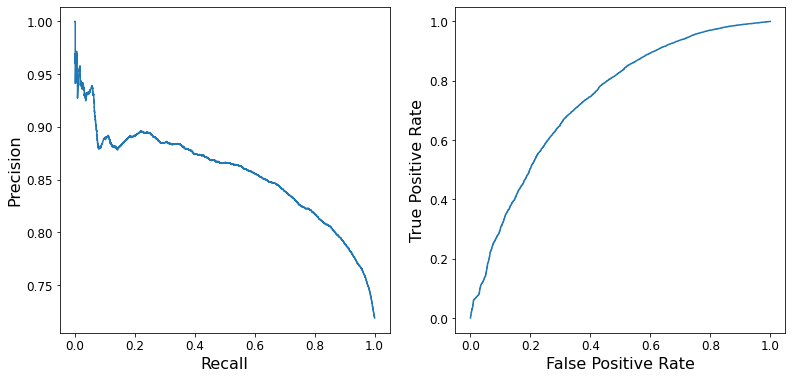

In [33]:
fig, axs = plt.subplots(1,2,figsize=(13,6))
precision, recall, thresholds = precision_recall_curve(y_test, lreg_best.predict_proba(x_test)[:,1])
axs[0].plot(recall,precision)
axs[0].set_xlabel("Recall",fontsize=16)
axs[0].set_ylabel("Precision",fontsize=16)
axs[0].tick_params(axis='both',labelsize=12)

# ax.tick_params(axis='x', Labelsize= )

fpr, tpr, thresholds = roc_curve(y_test, lreg_best.predict_proba(x_test)[:,1])
axs[1].plot(fpr,tpr)
axs[1].set_xlabel("False Positive Rate",fontsize=16)
axs[1].set_ylabel("True Positive Rate",fontsize=16)
axs[1].tick_params(axis='both',labelsize=12)

# plt.tight_layout()

plt.show()

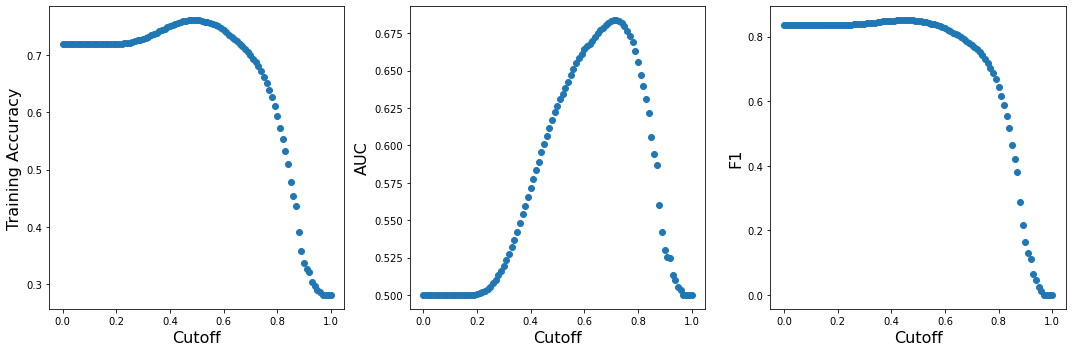

In [35]:
cutoffs = np.arange(0, 1.01, 0.01)
y_train_prob = lreg_best.predict_proba(x_train)[:,1]
accs = []
aucs = []
f1s = []
precision = []
recall = []
for cutoff in cutoffs:
    cutoffs = np.arange(0, 1.01, 0.01)
    y_train_pred = 1*(y_train_prob >= cutoff)
    
    #accs.append(np.sum(y_train_pred == y_train)/len(y_train))
    accs.append(accuracy_score(y_train, y_train_pred))
    aucs.append(roc_auc_score(y_train, y_train_pred))
    f1s.append(f1_score(y_train, y_train_pred))

fig, axs = plt.subplots(1,3,figsize=(15,5))

axs[0].scatter(cutoffs,accs)
axs[0].set_xlabel("Cutoff",fontsize=16)
axs[0].set_ylabel("Training Accuracy",fontsize=16)

axs[1].scatter(cutoffs,aucs)
axs[1].set_xlabel("Cutoff",fontsize=16)
axs[1].set_ylabel("AUC",fontsize=16)

axs[2].scatter(cutoffs,f1s)
axs[2].set_xlabel("Cutoff",fontsize=16)
axs[2].set_ylabel("F1",fontsize=16)  

plt.tight_layout()

# plt.figure(figsize=(12,8))
# plt.scatter(cutoffs,accs)
# plt.xlabel("Cutoff",fontsize=16)
# plt.ylabel("Training Accuracy",fontsize=16)
# plt.show()

# plt.figure(figsize=(12,8))
# plt.scatter(cutoffs,aucs)
# plt.xlabel("Cutoff",fontsize=16)
# plt.ylabel("AUC",fontsize=16)
# plt.show()

# plt.figure(figsize=(12,8))
# plt.scatter(cutoffs,f1s)
# plt.xlabel("Cutoff",fontsize=16)
# plt.ylabel("F1",fontsize=16)

plt.show()


# Random Forest with Hyperparameter Tuning

Becuase the Levenshtein distance served as the best string difference metric through the logistic regression analysis, we'll use this as the input data set for the following random forest model.

In [36]:
#Train Test Split Using Levensthein Columns
x_train, x_test, y_train, y_test = train_test_split(data[feature_dict['x_col_lev']], data['match'],
                                                    shuffle      = True,
                                                    random_state = 614,
                                                    test_size    = 0.2,
                                                    stratify     = data['match'])

## Hyperparameter Tuning

In [40]:
best_params = random_forest_pipe(features = data[feature_dict['x_col_lev']], labels = data['match'])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}


## Tuned Random Forest on Test Data

In [41]:
rf_best = RandomForestClassifier(best_params['n_estimators'], 
                                 max_features      = best_params['max_features'], 
                                 random_state      = 614,
                                 min_samples_split = best_params['min_samples_split'],
                                 min_samples_leaf  = best_params['min_samples_leaf'],
                                 max_depth         = best_params['max_depth'])

In [42]:
x_train, x_test, y_train, y_test = train_test_split(data[feature_dict['x_col_lev']], data['match'],
                                                    shuffle      = True,
                                                    random_state = 614,
                                                    test_size    = 0.2,
                                                    stratify     = data['match'])

In [43]:
rf_best.fit(x_train,y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, n_estimators=400,
                       random_state=614)

In [44]:
y_rf_pred = rf_best.predict(x_test)

In [45]:
f1_score(y_test, y_rf_pred)

0.8757186579331254

In [46]:
accuracy_score(y_test, y_rf_pred)

0.8154284015122553

In [47]:
roc_auc_score(y_test, y_rf_pred)

0.74601055625967

In [48]:
confusion_matrix(y_test, y_rf_pred)

array([[ 3888,  2731],
       [ 1614, 15308]])

In [49]:
rf_best.feature_importances_

array([0.10760246, 0.30253768, 0.14542356, 0.02195004, 0.00806806,
       0.03232869, 0.03941916, 0.1054869 , 0.23718345])

# Simple Models

## A Naive Model V1: (developed by Ling Zhou) 

In [50]:
baseline_cols = ['geo_diff', 'name_diff_lev', 'address_diff_lev']

In [51]:
x_train, x_test, y_train, y_test = train_test_split(data[baseline_cols], data['match'],
                                                    shuffle      = True,
                                                    random_state = 614,
                                                    test_size    = 0.2,
                                                    stratify     = data['match'])

In [52]:
def baseline(df, cols, thresh):
    df_copy = df.copy()
    df_copy['match'] = np.random.choice([True, False], len(df))
    df_copy.loc[df_copy[cols].max(axis=1)<thresh] = True
    
    return df_copy

In [53]:
# Using Levenshtein distance
#cols = ['location_diff','name_diff','address_diff']
#y_test = data['match']
y_pred = baseline(x_test, baseline_cols, 0.1).match
print(confusion_matrix(y_test,y_pred),'\n', roc_auc_score(y_test,y_pred))

[[ 3132  3487]
 [ 5377 11545]] 
 0.5777156107725611


In [54]:
f1_score(y_test, y_pred)

0.7226012392814671

In [55]:
accuracy_score(y_test, y_pred)

0.62346544326919

In [56]:
roc_auc_score(y_test, y_pred)

0.5777156107725611

## A Naive Model V2: Guess all matches are True

In [57]:
sample_arr = [True]

naive_pred = np.random.choice(sample_arr, len(y_test))

In [58]:
naive_pred

array([ True,  True,  True, ...,  True,  True,  True])

In [59]:
confusion_matrix(y_test, naive_pred)

array([[    0,  6619],
       [    0, 16922]])

In [60]:
roc_auc_score(y_test, naive_pred)

0.5

In [61]:
f1_score(y_test, naive_pred)

0.8364184563675457

In [62]:
accuracy_score(y_test, naive_pred)

0.7188309757444459